In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 3.1 MNIST

sklearn.datasets 패키디의 있는 함수는 대부분 세 종류이다.
* fetch_openml() - 데이터셋을 다운로드하기 위한 fetch_* 함수
* load_* - 사이킷런에 번드로 포함된 소규모 데이터셋을 로드하는 함수
* make_* - 테스트에 유용한 가짜 데이터셋을 생성하기 위한 함수

생성된 데이터셋은 일반적으로 넘파이 배열이고 입력과 타깃 데이터를 담은 (X, y) 튜플로 반환



fetch.openml() 함수는 조금 특이하게도 기본적으로 입력을 판다스 데이터프레임, 레이블을 판다스 시리즈로 반환한다.
<br>
하지만 MNIST 데이터셋은 이미지이므로 데이터프레임이 잘 맞지 않아서 as_frame=False로 지정하여 넘파이 배열로 데이터를 받는다.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('MNIST_784', as_frame=False)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target

print(X.shape)
print(y.shape)



(70000, 784)
(70000,)


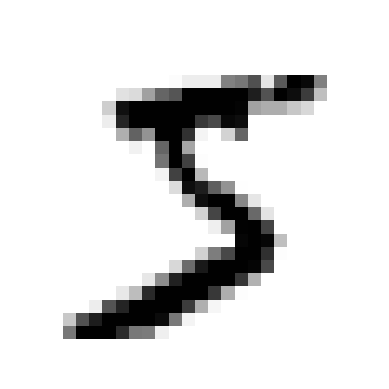

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()


In [5]:
y = y.astype(np.uint8)

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [7]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [8]:
y[0]

5

그림 저장: more_digits_plot


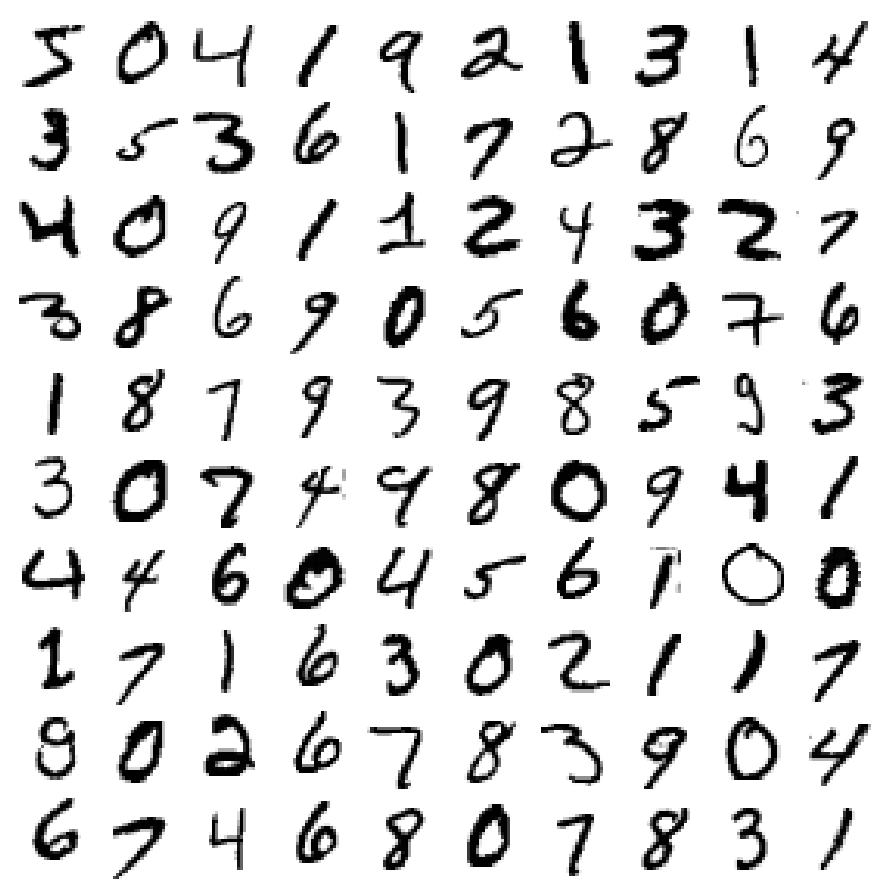

In [9]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [10]:
# 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 한다.
# fetch_openml()이 반환하는 mnist 데이터셋은 이미 훈련세트와 테스트세트가 나눠져 있다.

X_train, y_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

In [16]:
# 문제를 단순화해서 하나의 숫자 "5"만 식별해본다.

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [17]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [19]:
# 교차 검증 구현

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 데이터셋이 섞여있지 않다면 shuffle=True 추가!
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [21]:
# 더미 분류기로 비교
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
# False가 출력, True로 예측된 것이 없다.
print(any(dummy_clf.predict(X_train)))

False


In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [23]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.
<br>
특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.
<br>
분류기의 성능을 평가하는 더 좋은 방법은 **오차행렬**을 조사하는 것이다

### 3.3.2 오차 행렬

분류 모델의 성능을 평가하기 위해 사용되는 표 형식의 도구

In [25]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

* 첫번째 행 - 1열이 아니라고 한 경우
    * "5 아님" 이미지(음성클래스)에 대한 것으로, 53,892개를 '5 아님'으로 정확하게 분류했다(진짜 음성)는 의미이다.
    * 나머지 687개는 "5"라고 잘못 분류했다는 의미이다. (이것을 거짓 양성 또는 1종 오류)
* 두번째 행 - 2열이 맞다고 한 경우
    * "5"이미지 (양성클래스)에 대한 것으로 1891개를 "5 아님" 으로 잘못 분류했다. (거짓음성 또는 2종오류)
    * 3530개를 정확히 "5"라고 분류했다.(진짜 양성)

In [27]:
# 완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

양성 예측의 정확도 - 이를 분류기의 "정밀도"라고 한다.

$$정밀도 = \frac{TP} {TP + FP}$$

"TP"는 진짜 양성의 수, "FP"는 거짓 양성의 수이다.
<br>
___

정밀도는 **"재현율"**이라는 또 다른 지표와 같이 사용하는 것이 일반적이다.
<br>
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로, **"민감도"** 또는 **"진짜 양성비율(TPR)"**이라고도 한다.

$$재현율 = \frac{TP} {TP + FN}$$

"FN"은  거짓 음성의 수이다.
<br>
___


진짜 음성 샘플(TN), 거짓 양성(FP), 거짓 음성(FN), 진짜 양성(TP)의 그림 예시!

![다운로드](https://github.com/user-attachments/assets/71f97584-6527-43b5-aa1f-f80321c6e25b)

### 3.3.3 정밀도와 재현율

* 재현율은 모델이 실제로 긍정인 사례를 얼마나 잘 식별했는지를 나타냅니다. 다시 말해, 실제로 긍정인 것 중에서 모델이 긍정으로 올바르게 예측한 비율을 의미합니다.
    * 입력데이터가 올바르지만 잘못되었다고 판단하는 경우 - 낮은 재현율

* 정밀도는 모델이 긍정으로 예측한 사례 중에서 실제로 긍정인 사례의 비율을 나타냅니다. 즉, 모델의 긍정 예측이 얼마나 정확한지를 보여줍니다.
    * 입력 데이터가 정확히 예측한 경우 - 높은 정밀도


In [28]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))

print(recall_score(y_train_5, y_train_pred))


0.8370879772350012
0.6511713705958311


정밀도와 재현율을 $F_1$ 점수라고 하는 하나의 숫자로 만들면 편리할 때가 많다.
<br>
$F_1$ 점수는 정밀도와 재현율의 **조화 평균**이다.
<br>
보통의 평균은 모든 값을 동일하게 취급하지만 **조화 평균**은 낮은 값에서 훨씬 더 높은 비중을 둔다.
<br>
결과적으로 분류기의 $F_1$ 점수가 높아지려면 재현율과 정밀도가 모두 높아야한다.

$$F_1 = \frac {2}{\frac {1}{정밀도} + \frac {1}{재현율}} = 2 *\frac {정밀도*재현율}{정밀도+재현율} = \frac {TP}{TP+\frac {FN + FP}{2}} $$

In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

상황에 따라 정밀도가 중요할 수 있고 재현율이 중요할 수 있다.
<br>
정밀도와 재열율은 서로 반비례 관계이다. 이것을 "**정밀도/재현율 트레이드오프**" 라고 한다.

### 3.3.4 정미롣/재현율 트레이드오프

In [31]:
# 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.
# 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻는다.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

In [32]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

위 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여준다.
<br>
어떻게 하면 저절한 임곗값을 구할 수 있을까?

In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [42]:
# 위 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.
# 주어진 예측 점수(y_scores)에 따라 다양한 임계값을 기준으로 정밀도와 재현율을 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


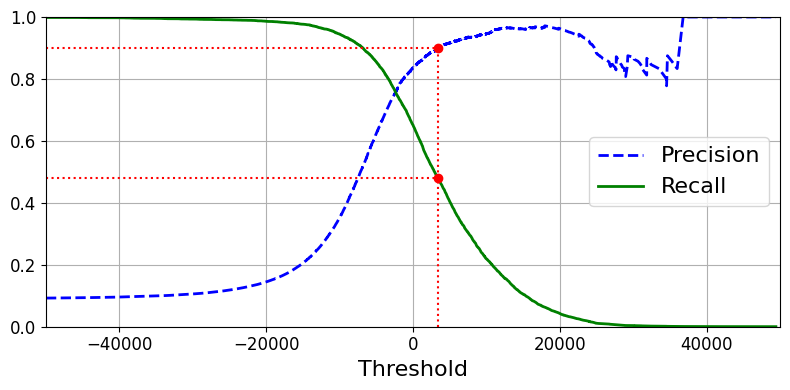

In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

그림 저장: precision_vs_recall_plot


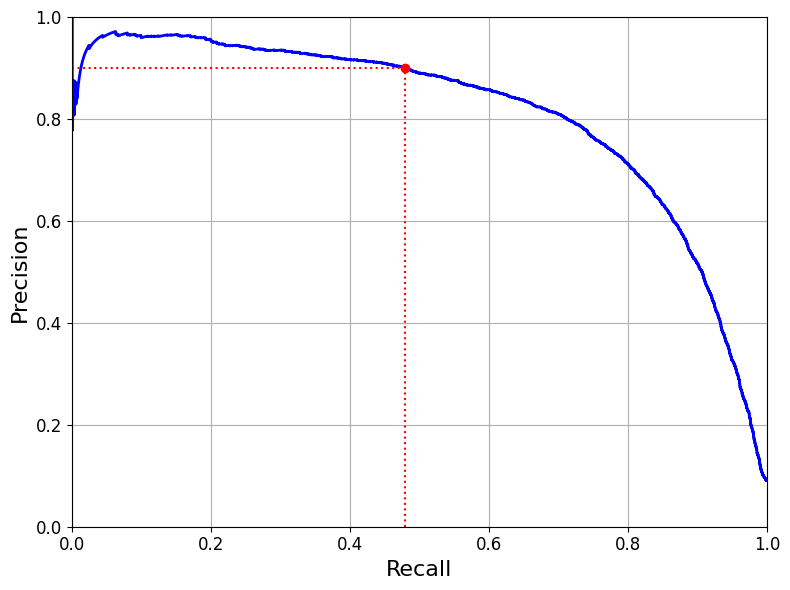

In [44]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

재현율 80% 근처에서 정밀도가 급격하게 줄어든다.
이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는게 좋다.


In [47]:
# 정밀도 90%를 달성하는 것이 목표라 가정하고 그래프에서 사용할 임곗값을 찾을 수 있지만 정확하지 않다.
# 다른 방법은 정밀도가 최소 90%가 되는 가장 낮은 임곗값을 찾는 것이다.
# armax() 메서드를 사용해 최댓값의 인덱스를 반환한다.
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [49]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [50]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [52]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

재현율이 너무 낮으면 높은 정밀도의 분류기는 전혀 유용하지 않다!!!
<br>
누군가 "99% 정밀도를 달성하자"라고 말하면 반드시 "재현율 얼마에서?"라고 물어봐야한다.

### 3.3.5 ROC 곡선

수신기 조작 특성(reciever operating characteristic) (ROC) 곡선도 이진 분류에서 널리 사용되는 도구이다.
<br>
거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선이다.
* FPR(또는 폴아웃이라고도 부른다.)은 양성으로 잘못 분류된 음성 샘플의 비율
    * 이는 1에서 음성으로 정확하게 분류한  음성 샘플의 비율인 진짜 음성 비율 (TNR)을 뺀 값이다.
* TNR을 "특이도"라고도 한다.
* ROC 곡선은 민감도(재현율)에 대한 1 - 특이도 그래프 이다.

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


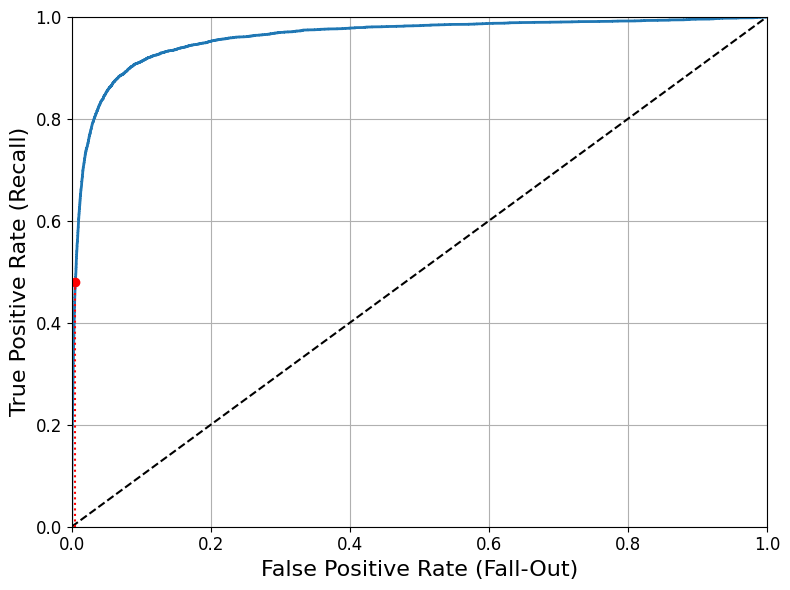

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()


빨간 점 부분이 가능한 모든 임곗값에서 진짜 양성 비율에 대한 거짓 양성 비율을 나타낸 ROC 곡선 (90%의 정밀도와 48%의 재현율)

여기에도 트레이드오프가 있다.
* 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성 비율(FPR)이 늘어난다.


In [56]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

NameError: name 'y_scoress' is not defined

일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때(재현율이 더 좋아야 할 때)  PR 곡선을 사용한다. 그렇지 않으면 ROC 곡선을 사용한다.


In [57]:
# RandomForestClassifier는 작동 방식 때무에 decision_function()을 제공하지 않는다.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [58]:
y_probas_forest = cross_val_predict(forest_clf,
                                    X_train,
                                    y_train,
                                    cv=3,
                                    method="predict_proba")

In [59]:
y_probas_forest[:2]

array([[0.  , 0.02, 0.02, 0.26, 0.  , 0.68, 0.  , 0.  , 0.01, 0.01],
       [0.99, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ]])

In [60]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


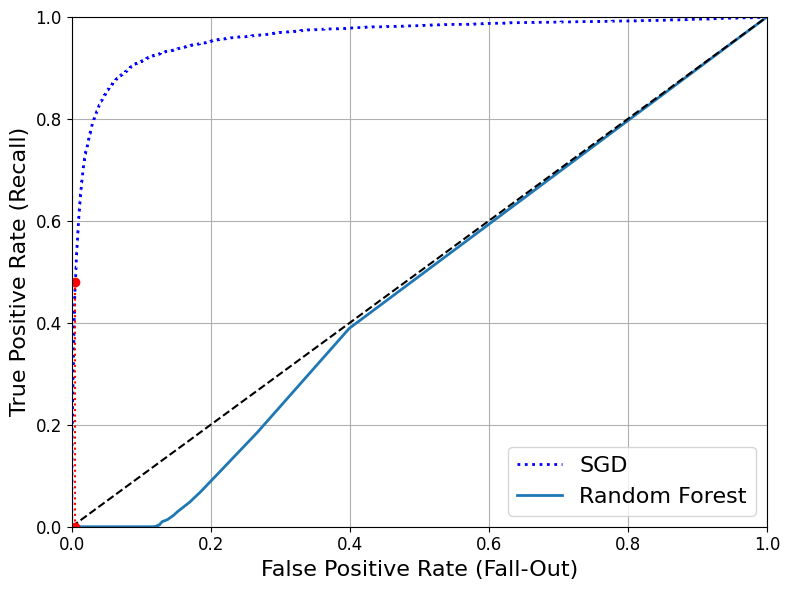

In [61]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [62]:
roc_auc_score(y_train_5, y_scores_forest)

0.46754636002160643

In [63]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [64]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591